# Epsilon-Greedy Algorithm for Loihi
Wilkie Olin-Ammentorp, Yury Sokolov, Maxim Bazhenov

In [1]:
import numpy as np
import bandit as b
import qtracker_demo as qt
import matplotlib.pyplot as plt

# Abstract
We present a spiking solution to the multi-arm bandit problem which closely corresponds to the traditional optimistic epsilon-greedy algorithm. Each arm of the bandit corresponds to a set of neurons which gradually fire with a rate which approaches the arm's expected reward the more it is sampled. These neurons implement a set of self-balancing dynamics which allow them to accurately track this expectation of signals which are sparse in time.

 # Q-Tracker Neuron
 One of the main challenges of implementing this algorithm is create a neuronal system which can efficiently represent the expected reward for each arm and update this given reward signals which can be sparse in time. To accomplish this, a multi-compartment system is used for each arm to create a neuron which will fire with a rate that represents the proportion of reward vs. punishment spikes it has received in the past.

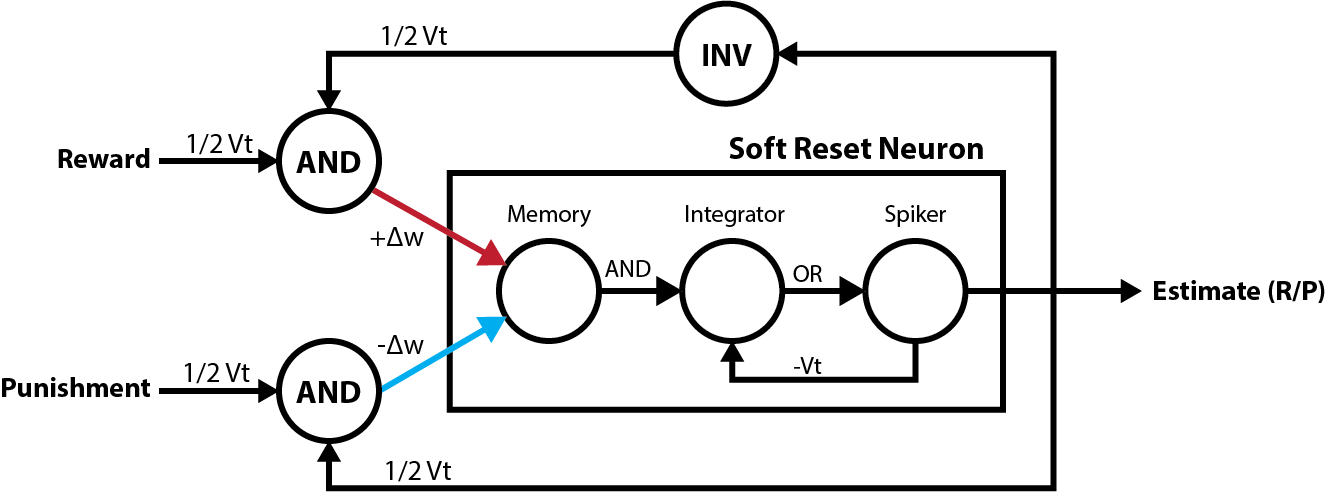

The core component of this 'Q-tracker' is the soft reset (SR) neuron, which fires with a rate linearly proportional to the memory compartment's voltage value over the integrator's threshold voltage. 

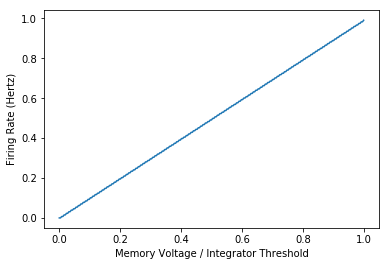

For the SR neuron to provide a firing rate which accurately represents the expected reward at this arm, the proportion of its memory voltage to integrator threshold must approach the proportion of reward to punishment spikes. These spikes may not arrive on a regular temporal basis, and the neuron must continue to provide an estimate based off its current knowledge in the meantime. 

To accomplish this, two competitive processes are established to adjust the memory voltage in the SR neuron: one excitatory process which can raise the memory voltage based off rewards, and one which can decrease the memory voltage based off punishments.

One important aspect of computing with spike-based systems is maintaining parameters within valid ranges through homeostatic or other mechanisms. In this particular case, the memory voltage cannot be increased every time the neuron receives a reward spike; if it is already at the maximum firing rate, it will do no good to increase the memory voltage further. Thus, we can impose a restriction on increasing the memory voltage: the chance a reward spike will cause it to increase is directly proportional to the inverse of the neuron's current firing rate (if it is low, always increase; if it is high, never increase).

Similarly for punishment spikes, the chance it will decrease the memory voltage is proportional to the neuron's current firing rate (if it is low, never decrease; if it is high, always decrease). By using these two simple rules applied to the soft reset neuron, the chance of an increase/decrease in memory voltage becomes equal once the firing rate approaches the ratio of reward vs. punishment spikes. 

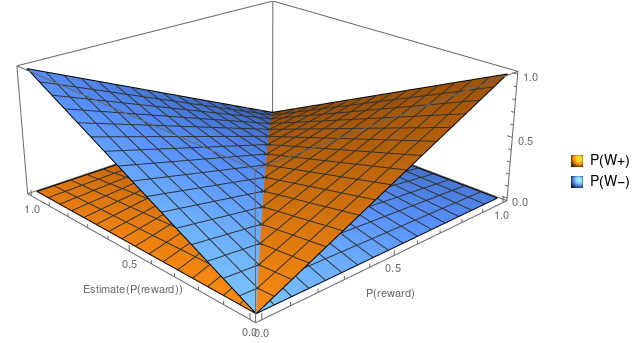

Here we demonstrate the activity of the Q-tracker neuron:

In [2]:
numTrackers = 20

In [3]:
(c, n, s) = qt.create_prototypes()
(net, exc, inh, probes) = qt.create_trackers(numTrackers, c_prototypes=c, n_prototypes=n, s_prototypes=s)

In [4]:
rewards = [net.createSpikeGenProcess(numPorts=1) for i in range(numTrackers)]
punishments = [net.createSpikeGenProcess(numPorts=1) for i in range(numTrackers)]

In [5]:
for i in range(numTrackers):
    rewards[i].connect(exc[i], s['halfconn'])
    punishments[i].connect(inh[i], s['halfconn'])

In [6]:
epoch = 20
n_rewards = 1000

In [7]:
(r, p) = qt.generate_times(numTrackers, n_rewards, epoch)
runtime = r[-1][-1]+epoch

for i in range(numTrackers):
    rewards[i].addSpikes([0], [r[i].tolist()])
    punishments[i].addSpikes([0], [p[i].tolist()])

In [8]:
net.run(runtime)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:43375
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
INFO:DRV:      Compiling Embedded snips....Done 0.30s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1588029220.5991385/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Encoding probes.............Done 1.13ms
INFO:DRV:      Configuring registers.......Done 7.31ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring spikes.........Done 0.13s
INFO:DRV:      Transferring probes.........Done 4.49ms
INFO:DRV:      Executing...................Done 6.86s
INFO:DRV:      Processing timeseries.......Done 3.78s
INFO:DRV:  Executor: 20000 timesteps.......Done 13.99s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


Over time, the memory voltages come to approach the expected rewards - effectively, they perform a random walk centered on the true reward parameter. 

Text(0.5,1,'Memory Voltages vs. Time')

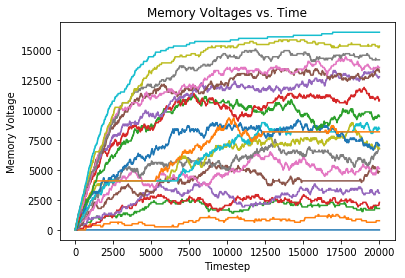

In [9]:
plt.plot(probes['weights'][0].data.T)
plt.xlabel("Timestep")
plt.ylabel("Memory Voltage")
plt.title("Memory Voltages vs. Time")

In [10]:
spks = probes['spks']

In [11]:
isrs = np.array([np.convolve(spks[0].data[i,:], np.ones(epoch*5), mode='valid')/(epoch*5) for i in range(numTrackers)])

The firing rates very closely follow the memory voltage as expected. However, because the process is a random walk, values can have errors which may cause immediate firing rates to not have the desired rank.

Text(0.5,1,'Time-Averaged Firing Rates of SR Neuron vs. Time')

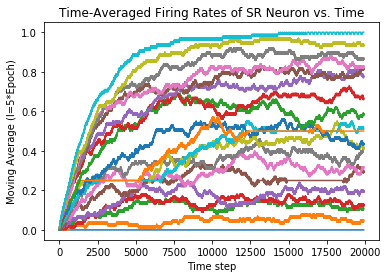

In [12]:
plt.plot(isrs.T)
plt.xlabel("Time step")
plt.ylabel("Moving Average (l=5*Epoch)")
plt.title("Time-Averaged Firing Rates of SR Neuron vs. Time")

In [13]:
avgrates = np.divide(np.cumsum(spks[0].data, axis=1), np.arange(spks[0].data.shape[1])[np.newaxis, :]).T

/homes/wolin/python3_venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


However, over time the expectation converges to the true value.

Text(0.5,1,'Total Spikes vs. Time')

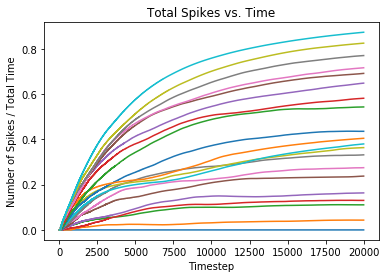

In [14]:
plt.plot(avgrates)
plt.xlabel("Timestep")
plt.ylabel("Number of Spikes / Total Time")
plt.title("Total Spikes vs. Time")

# Full Bandit

By using a series of Q-Trackers (one or more per arm, can add more neurons to get a more accurate estimate in fewer timesteps), the expected reward can be estimated by looking at the firing rate of the Q-tracker. A SNIP then determines for each fixed-length epoch whether to select the highest-firing arm, or a random arm (this may be replaced later by a spiking selection network). When an arm is selected, it is then updated by sending a reward or punishment spike depending on the reward outcome.

In [15]:
numArms = 10
excess = 0.2
neuronsPerArm = 1
epsilon = 0.08
tEpoch = 128
epochs = 2000

In [16]:
p_reward = b.pick_weights(numArms, excess)

In [17]:
bestarm = np.argmax(p_reward)

In [18]:
btest = b.bandit(numArms, neuronsPerArm, tEpoch, epochs, probabilities=p_reward, epsilon=epsilon, recordWeights=True)

In [19]:
(choices, rewards, spikes) = btest.run(epochs)
btest.stop()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:46003
INFO:DRV:      Host server up..............Done 0.14s
INFO:DRV:      Encoding axons/synapses.....Done 8.86ms
INFO:DRV:      Compiling Embedded snips....Done 0.28s
INFO:DRV:      Encoding probes.............Done 1.30ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1588029237.2729824/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring probes.........Done 3.52ms
INFO:DRV:      Transferring spikes.........Done 0.98ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments, done.
INFO:DRV:      Executing...................Done 45.11s
INFO:DRV:   

The system with ten arms and using a slightly-modified optimistic setup (the inverted firing of the SR neuron is used as the estimate signal, and reward/punishment inputs are swapped) converges fairly quickly to the optimal arm in this example.

Text(0.5,0,'Time step')

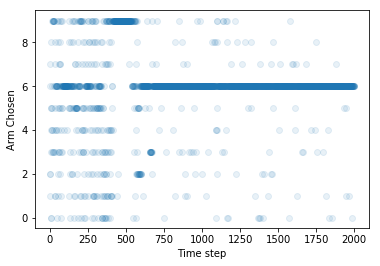

In [20]:
plt.scatter(np.arange(epochs), choices, alpha=0.1)
plt.ylabel("Arm Chosen")
plt.xlabel("Time step")

Text(0,0.5,'Proportion chosen & Probability of Reward')

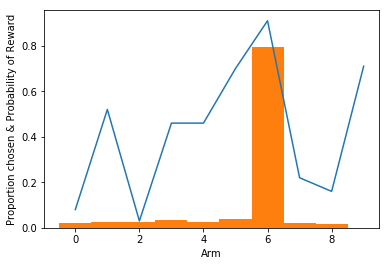

In [21]:
plt.plot(p_reward/100)
plt.hist(choices, bins=np.arange(numArms)-0.5, density=True)
plt.xlabel("Arm")
plt.ylabel("Proportion chosen & Probability of Reward")

Text(0,0.5,'Mean Optimal Action over last 5 epochs')

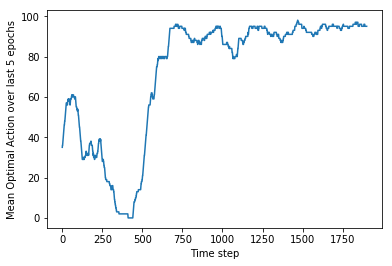

In [22]:
plt.plot(np.convolve([x == bestarm for x in choices], np.ones(epoch*5), mode='valid'))
plt.xlabel("Time step")
plt.ylabel("Mean Optimal Action over last 5 epochs")